# Data Cleaning and Preparation

### Importing Libraries|

In [658]:
import pandas as pd
import seaborn as sns
import geopandas as gpd

from dateutil import parser


### Importing Dataset

In [659]:
path = 'Data\DOE_Electric_Disturbance_Events.xlsx'
wb = pd.read_excel(path, sheet_name=None)


After manually exploring the dataset in Excel I identified key issues consolodating the dataset and data quality. My approach is the handle each issue step by step as a go a long, and was not expecting a linear process. 

I identified the following issues:

Issues for consolodating the data:

- Multiple column names have changed from 2010 onwards 
- The number of columns is not the same for all years
- The same type of data can be stored in different columns per year
- The data does not start on the first row, sometimes on the second
- Some years have a datetime column for the restoration date and time for an event, and in the latter years these are splitted into 2 separate columns
- In some sheets there is data in multiple rows that should be in one single cell
- There are many rows that don't contain data but information like table headers or totals. 

Data quality issues:
- Times are sometimes string based (e.g. 1:10 p.m. for example) that cannot be used in time measures and in other cases have a time format (e.g. 13:10:00)  
- In time columns there are sometimes descriptive texts like Approxitmatly or Midnigth instead of 00:00 
- In the column Area affected there is no consistency in how the data is stored, and how the affected area's are written. (inc. spelling mistakes, no clear difference between state and/or city)
- It's unclear what type of area is effected (e.g. is it a state, region or county for example)
- In the column NERC Region there are typo's, multiple regions per incident and regions unknown to the current situation (for example: ECAR is not a current region within the NERC and is most likely renamed or organized)
- The column event type is very incostistent and contains many spelling errors
- The column event type is more consistent from 2010 onwards
- In the columns loss of megawatts and number of customers expected, I expected number values. There are however lot of descriptive texts like million, peak, number of utilities or estimates. But also a lot of unknown values
- The alert criteria as needed to be filled in on the OE form currently, is only available since 2015 and therefore the type of emergency will not be easy to determine in the years before 2015




 Each issue requires a different approach and I expected not a straigthforward but iterative proces.

### Creating lists and functions for cleaning dataset

Before any cleaning can be done, all the rows that do not contain data need to be removed. I established that these particular rows all have certain values in the column "Date event began", and I by filtering out the rows that contain these values I can remove these rows. I created a list with these values that I can use later on. 

In [660]:
# List of values for filtering "Date Event Began" column
values_to_exclude = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october',
                     'november', 'december', 'none', 'table b.2.', 'date', 'date/time', 'date event began', 'ongoing', 'na', 'note', 'continued', 'estimated', 'source', 'http', 'information']

Because the datetime and time columns contain string values and have different formats, I needed to find a method that is replicable and can be easily applied to all values without the necessitaty of manual corrections.  

To do this, I created functions that I can apply to each row value, for:

-   Time columns
-   Date columns
-   Datetime columns

The functions firstly cleanup incorrect string values and then try to parce the strings with parser from dateutil library, when it gives an error it converts the string to numeric in the case of timestrings at tries to convert it through pandas to_datetime(). I added a safety net in the functions through printing the errors and returning the original value is an error is given. 
This way, I can manually check any errors given and make adjustments if necessary. As long as show_errors = True while performing the function, the errros will be printed and original value are maintained. When False, the function returns a pandas NaT value. Ensuring all the values in the column are considerd either time or date values. 

In [661]:
# Functions for cleaning and convert date, time and datetime values

# Parsing time strings
def parse_time_string(time_string, show_errors=False):
    if pd.notna(time_string):
        original_value = time_string

        # Remove incorrect string values before parsing
        try:
            time_string = time_string.lower().replace(',', ' ')
            time_string = time_string.lower().replace(': ', ':')
            time_string = time_string.lower().replace('noon', 'p.m.')           
            time_string = time_string.lower().replace('unknown', '')
            time_string = time_string.lower().replace('12:00 midnight', '00:00')
            time_string = time_string.lower().replace('midnight', '00:00')
            time_string = time_string.lower().replace('evening', '5 p.m.')
            time_string = time_string.lower().replace('ongoing', ' ')
            time_string = time_string.lower().replace('approximately', '')
            time_string = time_string.lower().replace('approximately ', '')

            # Parse time with parser
            parsed_time = parser.parse(time_string)
            formatted_time = parsed_time.strftime('%H:%M:%S')

            return formatted_time
        except ValueError as e:
            try:
                # If parser gives an error, try pd.to_datetime() or print error
                numeric_time = pd.to_numeric(
                    original_value, errors='coerce') * 24 * 3600
                formatted_time = pd.to_datetime(
                    numeric_time, unit='s', errors='coerce').time()
                
                return formatted_time
                        
            except ValueError as e:
                # If both approaches fail, print the error for checking and keep original value
                if show_errors and time_string != 'NaN' and time_string != 'nan' and time_string != 'nat':
                    print(f"Error parsing time string '{time_string}': {e}")
                return original_value

    else:
        return pd.NaT

# Parsing datetime strings


def parse_datetime_string(datetime_string, show_errors=False):
    if pd.notna(datetime_string):
        original_value = datetime_string

        # Remove incorrect string values before parsing
        try:
            datetime_string = datetime_string.lower().replace(',', ' ')
            datetime_string = datetime_string.lower().replace(': ', ':')
            datetime_string = datetime_string.lower().replace('noon', 'p.m.')
            datetime_string = datetime_string.lower().replace('midnight', 'a.m.')
            datetime_string = datetime_string.lower().replace('unknown', '')
            datetime_string = datetime_string.lower().replace('ongoing', '')
            datetime_string = datetime_string.lower().replace('12:00 midnight', '00:00')
            datetime_string = datetime_string.lower().replace('approximately', '')
            datetime_string = datetime_string.lower().replace('approximately ', '')
            datetime_string = datetime_string.lower().replace('(trans. only)', '')
            
            
            # Parse time with parser
            parsed_datetime = parser.parse(datetime_string)
            formatted_datetime = parsed_datetime.strftime('%Y-%m-%d %H:%M:%S')

            return pd.to_datetime(formatted_datetime)

        # Print error
        except ValueError as e:
            if show_errors and datetime_string != 'nan' and datetime_string != 'NaT' and datetime_string != 'nat':
                print(
                    f"Error parsing datetime string '{datetime_string}': {e}")
            return original_value

    else:
        return pd.NaT

# Parsing date strings


def parse_date_string(date_string, show_errors=False):
    if pd.notna(date_string):
        original_value = date_string

        # Remove incorrect string values before parsing
        try:
            date_string = date_string.lower().replace(',', ' ')
            date_string = date_string.lower().replace(': ', ':')
            date_string = date_string.lower().replace('//', '/')
            date_string = date_string.lower().replace('unknown', '')
            date_string = date_string.lower().replace('44641', '31-03-2022')         
                        
            # Parse time with parser
            parsed_date = parser.parse(date_string)
            formatted_date = parsed_date.strftime('%Y-%m-%d')
            
            return pd.to_datetime(formatted_date)
        
        # Print error
        except ValueError as e:
            if show_errors and date_string != 'NaT' and date_string != 'nat' and date_string != 'nan':
                print(f"Error parsing date string '{date_string}': {e}")
                
            return original_value
    else:
        return pd.NaT

There are also rows in the date, datetime or time columns that do not contain any date or time informtation, like "Unknown". I created a list and function to clean these values before parsing. 

In [662]:
values_to_replace = ['ongoing', 'unknown', 'unknown ','unkonwn', 'none', 'nan', 'NaT']

def replace_values(value):
    lower_value = str(value).lower().strip()
    if lower_value in [val.lower().strip() for val in values_to_replace]:
        return pd.NaT
    return value



To clean the columns Alert Criteria and Event Type, I created functions that extract: 

- Report Type (based on column Alert Criteria)
- Emergency Cause (based on column Event Type)
- Emergency Impact (based on column Event Type and Alert Criteria)
- Emergency Action (based on column Event Type and Alert Criteria) 

I created dimension tables in Excel for each of above mentioned outputs, and therefore, the functions return an ID that can be connectd in the datamodel in Power BI. 

In [663]:
def report_type_id(row):
    if pd.isna(row) or row == '':
        return None

    id_1 = ['physical attack that causes major interruptions or impacts']
    id_2 = ['cyber event that causes interruptions',
            'reportable cyber security incident']
    id_3 = ['complete operational failure']
    id_4 = ['islanding']
    id_5 = ['uncontrolled loss of 300 megawatts or more of firm system loads']
    id_6 = ['firm load shedding of 100 megawatts', 
            'load shedding of 100 megawatts or more', 'load shed 100']
    id_7 = ['voltage reductions of 3 percent', 'voltage reduction']
    id_8 = ['public appeal to reduce']
    id_9 = ['physical attack that could potentially impact electric power system', 'actual physical attack']
    id_10 = ['cyber event that could potentially impact electric power system',
             'cyber security incident that was an attempt to compromise', 'suspected cyber attack']
    id_11 = ['loss of electric service to more than 50,000 customers']
    id_12 = ['fuel supply emergencies that could impact electric power system']
    id_13 = ['damage or destruction of a facility within its reliability coordinator']
    id_14 = ['damage or destruction of its facility that results from actual or suspected intentional human action', 'suspected physical attack']
    id_15 = [
        'physical threat to its facility excluding weather or natural disaster related threats']
    id_16 = [
        'physical threat to its bulk electric system control center, excluding weather']
    id_17 = ['bulk electric system emergency resulting in voltage deviation',
             'voltage deviation equal to or greater than 10%']
    id_18 = [
        'uncontrolled loss of 200 megawatts or more of firm system loads for 15 minutes or more']
    id_19 = [
        'total generation loss, within one minute of: greater than or equal to 2,000 megawatts']
    id_20 = ['affecting a nuclear generating station']
    id_21 = ['unexpected transmission loss within its area, contrary to design, of three or more bulk electric system facilities']
    id_22 = ['unplanned evacuation']
    id_23 = [
        'complete loss of interpersonal communication and alternative interpersonal communication']
    id_24 = ['loss of monitoring or control']

    if any(keyword in row.lower() for keyword in id_1):
        return 1

    elif any(keyword in row.lower() for keyword in id_2):
        return 2

    elif any(keyword in row.lower() for keyword in id_3):
        return 3

    elif any(keyword in row.lower() for keyword in id_4):
        return 4

    elif any(keyword in row.lower() for keyword in id_5):
        return 5

    elif any(keyword in row.lower() for keyword in id_6):
        return 6

    elif any(keyword in row.lower() for keyword in id_7):
        return 7

    elif any(keyword in row.lower() for keyword in id_8):
        return 8

    elif any(keyword in row.lower() for keyword in id_9):
        return 9

    elif any(keyword in row.lower() for keyword in id_10):
        return 10

    elif any(keyword in row.lower() for keyword in id_11):
        return 11

    elif any(keyword in row.lower() for keyword in id_12):
        return 12

    elif any(keyword in row.lower() for keyword in id_13):
        return 13

    elif any(keyword in row.lower() for keyword in id_14):
        return 14

    elif any(keyword in row.lower() for keyword in id_15):
        return 15

    elif any(keyword in row.lower() for keyword in id_16):
        return 16

    elif any(keyword in row.lower() for keyword in id_17):
        return 17

    elif any(keyword in row.lower() for keyword in id_18):
        return 18

    elif any(keyword in row.lower() for keyword in id_19):
        return 19

    elif any(keyword in row.lower() for keyword in id_20):
        return 20

    elif any(keyword in row.lower() for keyword in id_21):
        return 21

    elif any(keyword in row.lower() for keyword in id_22):
        return 22

    elif any(keyword in row.lower() for keyword in id_23):
        return 23

    elif any(keyword in row.lower() for keyword in id_24):
        return 24

    else:
        return 24    


def emergency_cause_id(row):
    if pd.isna(row) or row == '':
        return

    id_1 = ["unknown"]
    id_2 = ['physical attack', 'sabotage', 'actual physical event',
            'suspected physical attack', 'suspected sabotage', 'suspected telecommunications attack']
    id_3 = ['threat of physical', 'potential physical attack']
    id_4 = ['vandalsim', 'vandalism']
    id_5 = ['theft']
    id_6 = ['suspicious activity']
    id_7 = []
    id_8 = ['cyber']
    id_9 = ["fuel supply"]
    id_10 = ['generator', 'generation inadequacy']
    id_11 = ['transmission equipment', 'transmission  equipment', 'transmission system', 'transmission level',
             'equipment trip', 'equipment failure', 'equipment malfunction', 'equipment faulted', 'transformer failure']
    id_12 = ["switch", "failure at high voltage substation", 'substation']
    id_13 = ['weather', 'natural disaster', 'storm', 'lightning', 'wind', 'tornado', 'hurricane', 'heat wave', 'heatwave'
             'earthquake', 'earthquake', 'wildfire', 'brush fire', 'tropical', 'ice', 'flood', 'rain', 'wild fire', 'high winds', 'high temperatures', 'wild land fire']
    id_14 = ["operator"]
    id_15 = ['other']

    if any(keyword in row.lower() for keyword in id_1):
        return 1

    elif any(keyword in row.lower() for keyword in id_3):
        return 3

    elif any(keyword in row.lower() for keyword in id_5):
        return 5

    elif any(keyword in row.lower() for keyword in id_4):
        return 4

    elif any(keyword in row.lower() for keyword in id_6):
        return 6

    elif any(keyword in row.lower() for keyword in id_2):
        return 2

    elif any(keyword in row.lower() for keyword in id_7):
        return 7

    elif any(keyword in row.lower() for keyword in id_8):
        return 8

    elif any(keyword in row.lower() for keyword in id_13):
        return 13

    elif any(keyword in row.lower() for keyword in id_9):
        return 9

    elif any(keyword in row.lower() for keyword in id_10):
        return 10

    elif any(keyword in row.lower() for keyword in id_11):
        return 11

    elif any(keyword in row.lower() for keyword in id_12):
        return 12

    elif any(keyword in row.lower() for keyword in id_14):
        return 14

    elif any(keyword in row.lower() for keyword in id_15):
        return 15

    else:
        return 15
    
    
def emergency_impact_id(row):
    if pd.isna(row) or row == '':
        return 17

    id_1 = ['none']
    id_2 = ['unplanned evacuation from its bulk electric system control center']
    id_3 = [ 'Complete loss of Interpersonal Communication and Alternative Interpersonal Communication capability', 'complete loss of monitoring or control capability']
    id_4 = ['damage', 'destruction']
    id_5 = ['electrical system separation','electric system separation' , 'islanding', 'electrical separation']   
    id_6 = ['complete operational failure', 'complete operational failure or shut down of the transmission and/or distribution electrical system', 'complete electric system failure']
    id_7 = ['three or more BES elements']
    id_8 = ['major distribution system']
    id_9 = ['uncontrolled loss of 200 mw']
    id_10 = ['loss of electric service to more than 50,000 customers']
    id_11 = ['voltage reductions of 3 percent']
    id_12 = ['bulk electric system emergency resulting in voltage deviation',
             'voltage deviation equal to or greater than 10%']
    id_13 = ['inadequate electric resources to serve load']
    id_14 = ['capacity loss of 1,400 mw']
    id_15 = ['capacity loss of 2,000 mw']
    id_16 = ['nuclear generating']
    id_17 = ['other']

    if any(keyword in row.lower() for keyword in id_1):
        return 1

    elif any(keyword in row.lower() for keyword in id_2):
        return 2

    elif any(keyword in row.lower() for keyword in id_3):
        return 3

    elif any(keyword in row.lower() for keyword in id_4):
        return 4

    elif any(keyword in row.lower() for keyword in id_5):
        return 5

    elif any(keyword in row.lower() for keyword in id_6):
        return 6

    elif any(keyword in row.lower() for keyword in id_7):
        return 7

    elif any(keyword in row.lower() for keyword in id_8):
        return 8

    elif any(keyword in row.lower() for keyword in id_9):
        return 9

    elif any(keyword in row.lower() for keyword in id_10):
        return 10

    elif any(keyword in row.lower() for keyword in id_11):
        return 11

    elif any(keyword in row.lower() for keyword in id_12):
        return 12

    elif any(keyword in row.lower() for keyword in id_13):
        return 13

    elif any(keyword in row.lower() for keyword in id_14):
        return 14

    elif any(keyword in row.lower() for keyword in id_15):
        return 15

    elif any(keyword in row.lower() for keyword in id_16):
        return 16

    elif any(keyword in row.lower() for keyword in id_17):
        return 17   
    
    else:
        return 17
    
    
def emergency_action_id(row):
    if pd.isna(row) or row == '':
        return 9
    id_1 = ['none']
    id_2 = ['load shedding of 100 megawatt', 'load shed 100+', 'load shed of 100+', ]
    id_3 = ['public appeal to reduce']
    id_4 = ['warning', 'alert', 'contingency plan', 'implementation of stage 2 electrical emergency plan', 'declaration of  transmission emergency', 'declared stage 1 electric emergency']
    id_5 = ['voltage reduction']   
    id_6 = ['shed interruptible load', 'interruptible load shed', '/interruptible load shed']
    id_7 = ['repaired', 'restored']
    id_8 = ['mitigation implemented', 'initiated interruption of air conditioner']
    id_9 = ['other']
          
    if any(keyword in row.lower() for keyword in id_1):
        return 1

    elif any(keyword in row.lower() for keyword in id_2):
        return 2

    elif any(keyword in row.lower() for keyword in id_3):
        return 3

    elif any(keyword in row.lower() for keyword in id_4):
        return 4

    elif any(keyword in row.lower() for keyword in id_5):
        return 5

    elif any(keyword in row.lower() for keyword in id_6):
        return 6

    elif any(keyword in row.lower() for keyword in id_7):
        return 7

    elif any(keyword in row.lower() for keyword in id_8):
        return 8
    
    elif any(keyword in row.lower() for keyword in id_9):
        return 9
    
    else:
        return 9   
    
  
# Adding ID based on report type

def update_impact_id(row):
    if row['Impact ID'] == 17 and row['Report Type ID'] == 22:
        return 2
    elif row['Impact ID'] == 17 and (row['Report Type ID'] == 23 or row['Report Type ID'] == 24):
        return 3
    elif row['Impact ID'] == 17 and (row['Report Type ID'] == 13 or row['Report Type ID'] == 14):
        return 4
    elif row['Impact ID'] == 17 and row['Report Type ID'] == 4:
        return 5
    elif row['Impact ID'] == 17 and row['Report Type ID'] == 18:
        return 9
    elif row['Impact ID'] == 17 and row['Report Type ID'] == 11:
        return 10
    elif row['Impact ID'] == 17 and row['Report Type ID'] == 7:
        return 11
    elif row['Impact ID'] == 17 and row['Report Type ID'] == 17:
        return 12
    elif row['Impact ID'] == 17 and row['Report Type ID'] == 20:
        return 16
    else:
        return row['Impact ID']
    
def update_action_id(row):
    if row['Action ID'] == 9 and row['Report Type ID'] == 6:
        return 2
    elif row['Action ID'] == 9 and row['Report Type ID'] == 8:
        return 3
    elif row['Action ID'] == 9 and row['Report Type ID'] == 7:
        return 5     
    else:
        return row['Action ID']       

In the columns Demand Loss (MW)	and Number of Customers Affected there are values "Unknown", however since in these columns I would expect numerical values I replace these with 0. I choose particular 0 in this case, because a NA value for instance, would be recognized by Power BI as null and would require additional formatting. 


In [664]:
strings_to_zero   = ['unknown']

def replace_string_to_zero(value):
    lower_value = str(value).lower()
    if lower_value in [val.lower() for val in strings_to_zero]:
        return 0
    return value

### Cleaning and concating the data

This is the first step in the proces where I clean and consolodate the dataset. In the step I iterate through all the sheets in the Excel workbook, clean up each sheet and concat the cleaned sheets to a single dataframe named: data.
The cleaning process is an iterative manual process by going through each printed errors and handling these errors by making adding for instance string values to the list: values_to_format or when there is no other option, a manual correction in the dataset. 

Because it's important to track all the changes that have been made I firstly created dataframes where I store all the rows that have been filtered out. Later in the process I create a dataframe that stores all rows that haven been modified from the original dataset through either manual or automatic modifications.

In the following step Cleaning and concatening the data I performed the following for each sheet:

Filtering:
-   Set the columnnames by finding the index of the first row where all columns have string values and then using this row for setting the column names
-   Remove all rows that came before the first row with the column names
-   Check if the column names contain names that differ from the current used names and rename them when found to ensure all the data has the identical column names. 
-   Store original data before performing filtering and cleaning
-   Filtering the sheetdate by:
    - Filtering out all empty rows
    - Filtering out all rows where column Date Event Began is NA
    - Filtering out the rows where the column Date Event Began contains values as per the list: values_to_exclude
    - Store the filtered rows in the dataframe: data_removed

Cleaning:
-   In the case the date and time for restoration are stored in a single column parsing the datetime column and splitting the datetime into date and time columns
-   Replace string values in date and time columns that lack date or time information
-   Parce the date and time columns and check and resolve errors during parsing


After the filtering and cleaning the sheetdata is concatted to the data dataframe and the dataframe is then filtered on the needed columns and sorted. 



In [665]:
# Create an empty dataframes
data = pd.DataFrame()
data_removed = pd.DataFrame()

# Iterate through individual sheets in the Excel workbook
for sheet_name, sheet_data in wb.items():
    
    # Find the index of the first row containing strings
    first_string_row = sheet_data[sheet_data.map(
        lambda x: isinstance(x, str)).all(axis=1)].index[0]     

    # Use the first string row as column names
    sheet_data.columns = sheet_data.iloc[first_string_row]

    # Remove rows before the first column name row
    sheet_data = sheet_data.iloc[first_string_row + 1:]

    # Rename column names 
    for old_column, new_column in {
        'Date': 'Date Event Began',
        'Time': 'Time Event Began',
        'Restoration': 'Restoration Time',
        'Type of Disturbance': 'Event Type',
        'Loss (megawatts)': 'Demand Loss (MW)',
        'Number of Customers Affected 1[1]': 'Number of Customers Affected 1',
        'Area': 'Area Affected',
        ' NERC Region': 'NERC Region'
    }.items():
        if old_column in sheet_data.columns:
            sheet_data = sheet_data.rename(columns={old_column: new_column})

   # Store the original data before filtering
    original_data = sheet_data.copy()

     # Filter out all empty rows
    sheet_data = sheet_data.dropna(how='all')
    
    # Filter out rows where date event began is NA
    sheet_data = sheet_data[~pd.isna(sheet_data['Date Event Began'])]   

   # Filter out rows with values to exclude using from date event began column
    sheet_data = sheet_data[sheet_data['Date Event Began'].apply(
        lambda x: all(val.lower() not in str(x).lower() for val in values_to_exclude))]

    # Calculate what rows are filtered out and store it in data_removed dataframe
    removed_rows = original_data.merge(
        sheet_data, how='outer', indicator=True).loc[lambda x: x['_merge'] == 'left_only'].drop('_merge', axis=1)

    data_removed = pd.concat([data_removed, removed_rows], ignore_index=True)

    # Handle the sheets where the restoration date and time are in single column and split the column
    if 'Restoration Time' in sheet_data.columns:
        
        # Clean rows with string and no date and time values to pd.NaT
        sheet_data['Restoration Time'] = sheet_data['Restoration Time'].apply(replace_values)
        
        # Parse the datetime column to datetime dtype and check for errors
        sheet_data['Restoration Time'] = sheet_data['Restoration Time'].astype(
            str).apply(parse_datetime_string, show_errors=True)               
            
        # Split columns if all errors are solved
        sheet_data[['Date of Restoration', 'Time of Restoration']] = sheet_data['Restoration Time'].apply(
            lambda x: pd.Series(str(x).split(' ', 1) if pd.notna(x) else [None, None])
        )
     
    # Parse Date and time columns    
        
    # Clean rows with string and no date and time values to pd.NaT
    sheet_data['Date of Restoration'] = sheet_data['Date of Restoration'].apply(replace_values)
    sheet_data['Time of Restoration'] = sheet_data['Time of Restoration'].apply(replace_values)
     
    # Parse date and time columns
    sheet_data["Date Event Began"] = sheet_data["Date Event Began"].astype(
        str).apply(parse_date_string, show_errors=True)
                
    sheet_data["Time Event Began"] = sheet_data["Time Event Began"].astype(
        str).apply(parse_time_string, show_errors=True)

    sheet_data["Date of Restoration"] = sheet_data["Date of Restoration"].astype(
        str).apply(parse_date_string, show_errors=True)
    
    sheet_data['Time of Restoration'] = sheet_data['Time of Restoration'].astype(
        str).apply(parse_time_string, show_errors=True)

    sheet_data["Date of Restoration"] = pd.to_datetime(sheet_data["Date of Restoration"])
    
    # Concatenate the modified sheet data to the data dataframe
    data = pd.concat([data, sheet_data], ignore_index=True)
 

# Filter out unnecesary columns
data = data[['Date Event Began', 'Time Event Began', 'Date of Restoration',	'Time of Restoration',	'Area Affected',
         'NERC Region',	'Alert Criteria', 'Event Type', 'Demand Loss (MW)', 'Number of Customers Affected']]   

# Sorting dataset and adding Event ID column
data.sort_values(by='Date Event Began', ascending=True, inplace=True) 

data.reset_index(drop=True,inplace=True)


data.head()   

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected
0,2002-01-29,17:00:00,NaT,NaT,Metropolitan Kansas City Area,SPP,NaN,Ice Storm,500-600,270000
1,2002-01-30,06:00:00,2002-02-07,12:00:00,Oklahoma,SPP,NaN,Ice Storm,500,1881134
2,2002-01-30,16:00:00,2002-02-10,21:00:00,Missouri,SPP,NaN,Ice Storm,210,95000
3,2002-02-27,10:48:00,2002-02-27,11:35:00,California,WSCC,NaN,Interruption of Firm Load,300,255000
4,2002-03-09,00:00:00,2002-03-11,12:00:00,Lower Peninsula of Michigan,ECAR,NaN,Severe Weather,190,190000


In [666]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3950 entries, 0 to 3949
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date Event Began              3950 non-null   datetime64[ns]
 1   Time Event Began              3950 non-null   object        
 2   Date of Restoration           3587 non-null   datetime64[ns]
 3   Time of Restoration           3950 non-null   object        
 4   Area Affected                 3950 non-null   object        
 5   NERC Region                   3930 non-null   object        
 6   Alert Criteria                2259 non-null   object        
 7   Event Type                    3950 non-null   object        
 8   Demand Loss (MW)              3561 non-null   object        
 9   Number of Customers Affected  3044 non-null   object        
dtypes: datetime64[ns](2), object(8)
memory usage: 308.7+ KB


In [667]:
data.isnull().sum()

Date Event Began                   0
Time Event Began                   0
Date of Restoration              363
Time of Restoration                0
Area Affected                      0
NERC Region                       20
Alert Criteria                  1691
Event Type                         0
Demand Loss (MW)                 389
Number of Customers Affected     906
dtype: int64

After cleaning and concatenating each sheet there are still more issues to be solved. I continued with cleaning the column area affected because it's important for the analysis that the impact on the grid can be analyzed. For this only looking per region will not be enough because a region covers multiple states and therefore significant parts of the grid. 

Based on analyzing the dataset I came to the conclusion that also for this data the quality goes down before 2015. From 2015 and onwards the data appears very consistent with mentioning the states, or the counties and/or cities with their state. This information is critical to determine which county for instance it is, because there can be multiple counties with the same name in different states. 

I also determined this for the data concerning the event type, that is very inconsistent before 2015, and the missing of the alert criteria that is necessary to determine if an incident was an emergency for instance, and what the cause and impact was. 

I therefore choose to first separate the dataset from 2015 and later and start extracting the states and counties from the Area Affected column since they can be used in Power BI. 

The other years do not have the same granularity what makes comparing the old data with the data from 2015 and newer very hard and I will add this data to power bi for a seperate dashboard. 

In [668]:
data_from_2015 = data[data['Date Event Began']>= '01-01-2015'].copy()

data_from_2015.head()

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected
1691,2015-01-07,17:00:00,2015-01-08,08:35:00,Tennessee,SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,Unknown,Unknown
1692,2015-01-07,17:00:00,2015-01-08,08:35:00,"Tennessee, Kentucky, Virginia, North Carolina,...",SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,Unknown,Unknown
1693,2015-01-22,04:24:00,2015-01-22,05:55:00,"Portland, Oregon",WECC,Suspected Physical Attack,Vandalism,Unknown,Unknown
1694,2015-01-26,14:39:00,2015-01-26,14:40:00,"Cave Junction, Oregon",WECC,Suspected Physical Attack,Vandalism,Unknown,Unknown
1695,2015-01-27,10:30:00,2015-01-27,10:31:00,"Kountze, Texas",SERC,Suspected Physical Attack,Sabotage,0,0


The first column I clean is the column NERC Region. I started by looking into the different regions stored in the column. 

In [669]:
data_from_2015['NERC Region'].value_counts(dropna=False)

NERC Region
WECC              690
SERC              453
TRE               286
RF                265
NPCC              210
MRO               145
RFC                42
SPP RE             41
FRCC               34
SPP                19
SERC/RF            12
RF/SERC             9
PR                  8
SERC/MRO            7
MRO/RF              7
NaN                 6
MRO/SERC            5
TRE/SERC            5
WECC/MRO            3
TRE/WECC            2
RF/MRO              2
TRE/SERC/WECC       1
SPP, SERC, TRE      1
WECC/SERC           1
RE                  1
WECC                1
MRO / RF            1
SERC / RF           1
RF                  1
Name: count, dtype: int64

Based on the information I gathered from the NERC website I was able to identify some comon errors:

- RF is RFC 
- RE is TRE 
- FRCC is SERC 

In the columns with NaN values I identified that this is causes by either the state Hawaii (HI) or Puerto Rico (PR). 

I replaced the NERC values RF and RE and then added HI or PR for the NaN values. 

In [670]:
# Trim leading and trailing whitespaces in the "NERC Region" column and replace values
data_from_2015["NERC Region"] = data_from_2015["NERC Region"].str.strip()    

nerc_values_replace =  {
    "RF": "RFC",     
    "RE": "TRE",
    "FRCC": "SERC", 
    "SPP RE": "SPP/TRE",
    "RF/SERC": "RFC/SERC",
    "SERC/RF":  "RFC/SERC",
    "SERC / RF": "RFC/SERC",
    "SERC/MRO": "MRO/SERC",
    "MRO/RF": "MRO/RFC",
    "MRO / RF": "MRO/RFC",
    "WECC/MRO": "MRO/WECC",
    "RF/MRO": "MRO/RFC",
    "SPP, SERC, TRE": "SPP/SERC/TRE",
    "WECC/SERC": "SERC/WECC" 
}

data_from_2015["NERC Region"] = data_from_2015["NERC Region"].replace(nerc_values_replace)

# Add HI and PR if NERC Region is NA
data_from_2015.loc[data_from_2015["NERC Region"].isna() & data_from_2015["Area Affected"].str.lower().str.contains("puerto rico", case=False, na=False), "NERC Region"] = "PR"
data_from_2015.loc[data_from_2015["NERC Region"].isna() & data_from_2015["Area Affected"].str.lower().str.contains("hawaii", case=False, na=False), "NERC Region"] = "HI"

In [671]:
data_from_2015['NERC Region'].value_counts(dropna=False).sort_values()

NERC Region
SERC/WECC          1
SPP/SERC/TRE       1
TRE/SERC/WECC      1
TRE/WECC           2
MRO/WECC           3
TRE/SERC           5
MRO/RFC           10
MRO/SERC          12
PR                14
SPP               19
RFC/SERC          22
SPP/TRE           41
MRO              145
NPCC             210
TRE              287
RFC              308
SERC             487
WECC             691
Name: count, dtype: int64

#### Adding Event Type and Emergency cause, impact and action ID columns

During this step, I continuously monitored the output and made changes the filters in the functions to ensure correct output. It was therefore an iterative process until the final result. 

In [672]:
# Report Type ID
data_from_2015["Report Type ID"] = data_from_2015["Alert Criteria"].apply(report_type_id)

# Emergency Cause ID
data_from_2015["Cause ID"] = data_from_2015["Event Type"].apply(emergency_cause_id)

# Emergency Impact ID
data_from_2015["Impact ID"] = data_from_2015["Event Type"].apply(emergency_impact_id)
data_from_2015['Impact ID'] = data_from_2015.apply(update_impact_id, axis=1)

# Emergency Action ID
data_from_2015["Action ID"] = data_from_2015["Event Type"].apply(emergency_action_id)
data_from_2015['Action ID'] = data_from_2015.apply(update_action_id, axis=1)   


In [673]:
data_from_2015.head()

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,Report Type ID,Cause ID,Impact ID,Action ID
1691,2015-01-07,17:00:00,2015-01-08,08:35:00,Tennessee,SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,Unknown,Unknown,8,13,17,3
1692,2015-01-07,17:00:00,2015-01-08,08:35:00,"Tennessee, Kentucky, Virginia, North Carolina,...",SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,Unknown,Unknown,8,13,17,3
1693,2015-01-22,04:24:00,2015-01-22,05:55:00,"Portland, Oregon",WECC,Suspected Physical Attack,Vandalism,Unknown,Unknown,14,4,4,9
1694,2015-01-26,14:39:00,2015-01-26,14:40:00,"Cave Junction, Oregon",WECC,Suspected Physical Attack,Vandalism,Unknown,Unknown,14,4,4,9
1695,2015-01-27,10:30:00,2015-01-27,10:31:00,"Kountze, Texas",SERC,Suspected Physical Attack,Sabotage,0,0,14,2,4,9


I first started to extract the states, counties, and cities from the Area Affected column. For this I used a list of all the counties and states and iterate through each row I I found one of those values. 

#### Replacing Unknown values to 0

In [674]:
data_from_2015['Demand Loss (MW)'] = data_from_2015['Demand Loss (MW)'].replace('Unknown',0)
data_from_2015['Number of Customers Affected'] = data_from_2015['Number of Customers Affected'].replace('Unknown', 0)
data_from_2015['Number of Customers Affected'] = data_from_2015['Number of Customers Affected'].replace(pd.NA, 0)

In [675]:
data_from_2015.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2259 entries, 1691 to 3949
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date Event Began              2259 non-null   datetime64[ns]
 1   Time Event Began              2259 non-null   object        
 2   Date of Restoration           1930 non-null   datetime64[ns]
 3   Time of Restoration           2259 non-null   object        
 4   Area Affected                 2259 non-null   object        
 5   NERC Region                   2259 non-null   object        
 6   Alert Criteria                2259 non-null   object        
 7   Event Type                    2259 non-null   object        
 8   Demand Loss (MW)              2259 non-null   object        
 9   Number of Customers Affected  2259 non-null   object        
 10  Report Type ID                2259 non-null   int64         
 11  Cause ID                      22

### Enhancing Dataset

I added a column that shows the total outage time, calculated by subtracting the start of the event from the end of the event. 

In [649]:
data_from_2015['Outage Time'] = (data_from_2015['Date of Restoration'] + pd.to_timedelta(data_from_2015['Time of Restoration'])) - (data_from_2015['Date Event Began'] + pd.to_timedelta(data_from_2015['Time Event Began']))
data_from_2015['Outage Time'] = data_from_2015['Outage Time'].dt.total_seconds()  / 60
data_from_2015.head()

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,Report Type ID,Cause ID,Impact ID,Action ID,Outage Time
1691,2015-01-07,17:00:00,2015-01-08,08:35:00,Tennessee,SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,0,0,8,13,17,3,935.0
1692,2015-01-07,17:00:00,2015-01-08,08:35:00,"Tennessee, Kentucky, Virginia, North Carolina,...",SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,0,0,8,13,17,3,935.0
1693,2015-01-22,04:24:00,2015-01-22,05:55:00,"Portland, Oregon",WECC,Suspected Physical Attack,Vandalism,0,0,14,4,4,9,91.0
1694,2015-01-26,14:39:00,2015-01-26,14:40:00,"Cave Junction, Oregon",WECC,Suspected Physical Attack,Vandalism,0,0,14,4,4,9,1.0
1695,2015-01-27,10:30:00,2015-01-27,10:31:00,"Kountze, Texas",SERC,Suspected Physical Attack,Sabotage,0,0,14,2,4,9,1.0


In [650]:
data_from_2015.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2259 entries, 1691 to 3949
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date Event Began              2259 non-null   datetime64[ns]
 1   Time Event Began              2259 non-null   object        
 2   Date of Restoration           1930 non-null   datetime64[ns]
 3   Time of Restoration           2259 non-null   object        
 4   Area Affected                 2259 non-null   object        
 5   NERC Region                   2259 non-null   object        
 6   Alert Criteria                2259 non-null   object        
 7   Event Type                    2259 non-null   object        
 8   Demand Loss (MW)              2259 non-null   object        
 9   Number of Customers Affected  2259 non-null   object        
 10  Report Type ID                2259 non-null   int64         
 11  Cause ID                      22

In [651]:
data_from_2015.describe()

,Date Event Began,Date of Restoration,Report Type ID,Cause ID,Impact ID,Action ID,Outage Time
count,2259,1930,2259.000000,2259.000000,2259.000000,2259.000000,1930.000000
mean,2020-02-20 07:17:17.450199040,2020-02-22 06:52:36.062176,13.333776,10.610447,10.750775,8.493581,876.638342
min,2015-01-07 00:00:00,2015-01-08 00:00:00,1.000000,1.000000,2.000000,2.000000,-525227.000000
25%,2018-08-27 00:00:00,2018-09-15 12:00:00,11.000000,6.000000,4.000000,9.000000,41.000000
50%,2020-08-04 00:00:00,2020-08-08 00:00:00,11.000000,13.000000,10.000000,9.000000,220.000000
75%,2021-12-20 00:00:00,2021-12-18 18:00:00,15.000000,15.000000,17.000000,9.000000,1053.500000
max,2023-06-30 00:00:00,2023-06-28 00:00:00,24.000000,15.000000,17.000000,9.000000,58920.000000
std,NaN,NaN,5.482411,4.542253,5.600388,1.710523,12344.422238


It appears there are rows where the outage time is less then 0 minutes, which can't be possible. I filter the dataset to review these rows.

In [652]:
data_from_2015[data_from_2015['Outage Time'] < 0]

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,Report Type ID,Cause ID,Impact ID,Action ID,Outage Time
2525,2019-08-18,16:47:00,2018-08-18,23:00:00,Texas:,TRE,Uncontrolled loss of 300 Megawatts or more of ...,Distribution Interruption,752,86373,5,15,17,9,-525227.0


In the dataset the 2018-08-18 can also be found, and it appears this is a type. I change the date to 2019-08-18	

In [653]:
data_from_2015.loc[2525, 'Date of Restoration'] = pd.to_datetime('2019-08-18')

In [676]:
data_from_2015['Outage Time'] = (data_from_2015['Date of Restoration'] + pd.to_timedelta(data_from_2015['Time of Restoration'])) - (data_from_2015['Date Event Began'] + pd.to_timedelta(data_from_2015['Time Event Began']))
data_from_2015['Outage Time'] = data_from_2015['Outage Time'].dt.total_seconds()  / 60

In [656]:
data_from_2015[data_from_2015['Outage Time'].dt.total_seconds()  / 60 < 0]

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,Report Type ID,Cause ID,Impact ID,Action ID,Outage Time


In [657]:
data_from_2015.describe()

,Date Event Began,Date of Restoration,Report Type ID,Cause ID,Impact ID,Action ID,Outage Time
count,2259,1930,2259.000000,2259.000000,2259.000000,2259.000000,1930
mean,2020-02-20 07:17:17.450199040,2020-02-22 11:24:55.958549248,13.333776,10.610447,10.750775,8.493581,0 days 19:08:58.196891191
min,2015-01-07 00:00:00,2015-01-08 00:00:00,1.000000,1.000000,2.000000,2.000000,0 days 00:00:00
25%,2018-08-27 00:00:00,2018-09-17 06:00:00,11.000000,6.000000,4.000000,9.000000,0 days 00:41:15
50%,2020-08-04 00:00:00,2020-08-08 00:00:00,11.000000,13.000000,10.000000,9.000000,0 days 03:40:00
75%,2021-12-20 00:00:00,2021-12-18 18:00:00,15.000000,15.000000,17.000000,9.000000,0 days 17:33:30
max,2023-06-30 00:00:00,2023-06-28 00:00:00,24.000000,15.000000,17.000000,9.000000,40 days 22:00:00
std,NaN,NaN,5.482411,4.542253,5.600388,1.710523,2 days 01:30:35.418571758


<Axes: ylabel='Outage Time'>

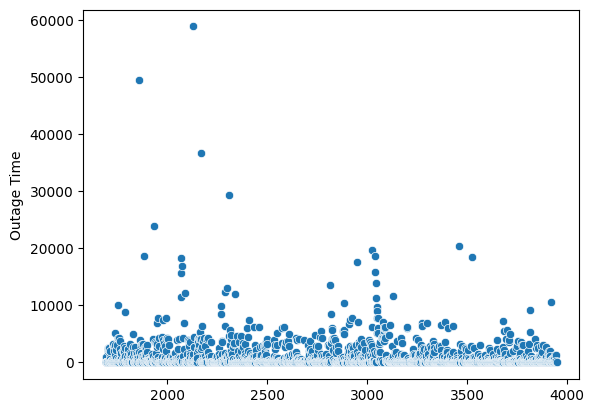

In [620]:
sns.scatterplot(data_from_2015['Outage Time'].dt.total_seconds()  / 60)

It appears that there are outliers above the 20.000 minutes (more then 13 days). There are also no other reasons to suspect outliers. 

In [621]:
data_from_2015[data_from_2015['Outage Time'] > 20000]

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,Report Type ID,Cause ID,Impact ID,Action ID,Outage Time
1856,2016-03-03,11:00:00,2016-04-06,19:47:00,California: San Bernardino County;,WECC,Fuel supply emergencies that could impact elec...,Fuel Supply Deficiency,0,0,12,9,17,9,49487.0
1931,2016-09-08,08:30:00,2016-09-25,00:00:00,New York: Tompkins County;,NPCC,Fuel supply emergencies that could impact elec...,Fuel Supply Deficiency,210,0,12,9,17,9,23970.0
2128,2018-01-02,10:00:00,2018-02-12,08:00:00,New York: Niagara County;,NPCC,Fuel supply emergencies that could impact elec...,Fuel Supply Deficiency,675,0,12,9,17,9,58920.0
2169,2018-03-12,00:00:00,2018-04-06,11:00:00,New York: Dutchess County;,NPCC,Physical attack that could potentially impact ...,Vandalism,0,0,9,4,17,9,36660.0
2308,2018-11-08,07:16:00,2018-11-28,16:32:00,California: Butte County;,WECC,Electrical System Separation (Islanding) where...,Natural Disaster/Transmission Interruption,32,11844,4,13,5,9,29356.0
3459,2022-03-17,12:59:00,2022-03-31,16:38:00,North Carolina: Durham County;,SERC,Damage or destruction of its Facility that res...,Actual Physical Attack/Vandalism,0,0,14,4,4,9,20379.0


By looking at the data and the type of events I don't think these values can be considered outliers. It's not that strange that there is a fuel deficiency for couple of days or that repairing damage takes a couple of days. 

#### Check duplicate rows

In [622]:
mask_duplicates = data_from_2015.duplicated(subset=['Date Event Began', 'Time Event Began', 'Date of Restoration', 'Time of Restoration'], keep=False)

duplicates = data_from_2015[mask_duplicates]

duplicates

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,Report Type ID,Cause ID,Impact ID,Action ID,Outage Time
1691,2015-01-07,17:00:00,2015-01-08,08:35:00,Tennessee,SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,0,0,8,13,17,3,935.0
1692,2015-01-07,17:00:00,2015-01-08,08:35:00,"Tennessee, Kentucky, Virginia, North Carolina,...",SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,0,0,8,13,17,3,935.0
2037,2017-05-28,19:30:00,2017-05-29,22:00:00,Louisiana: Texas,SERC,"Loss of electric service to more than 50,000 c...",Severe Weather,0,103000,11,13,10,9,1590.0
2039,2017-05-28,19:30:00,2017-05-29,22:00:00,Texas: Louisiana,TRE,"Loss of electric service to more than 50,000 c...",Severe Weather,0,103000,11,13,10,9,1590.0
2062,2017-07-22,22:00:00,NaT,NaT,Missouri,SERC,"Loss of electric service to more than 50,000 c...",Severe Weather,0,131000,11,13,10,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3740,2022-12-06,00:00:00,2022-12-06,00:01:00,Georgia: Bartow County;,SERC,Physical threat to its Facility excluding weat...,Suspicious Activity,0,0,15,6,17,9,1.0
3853,2023-03-03,15:40:00,NaT,NaT,"Kentucky: Oldham County, Jefferson County, Fay...",SERC,"Loss of electric service to more than 50,000 c...",Severe Weather,0,346000,11,13,10,9,NaN
3858,2023-03-03,15:40:00,NaT,NaT,"Kentucky: Oldham County, Jefferson County, Fay...",SERC,"Loss of electric service to more than 50,000 c...",Severe Weather,0,0,11,13,10,9,NaN
3859,2023-03-04,07:05:00,2023-03-04,07:06:00,Louisiana:,SERC,Uncontrolled loss of 300 Megawatts or more of ...,Transmission Interruption,800,0,5,15,17,9,1.0


Based on checking the duplicate rows I removed the rows with index:

- 1691
- 2037
- 2062 and 2063 (based on analyzing the dataset, there is a complementary row in the dataset)

- 2134 
- 2147
- 2409
- 2575
- 2590
- 2602
- 2673
- 3051
- 3069
- 3070
- 3096
- 3227
- 3299
- 3312
- 3377
- 3377 and 3378 (both have unknown restoration time, and when looking at the dataset there are more incidents (weather) with same causes in same region that have restoration date. Therefore these are likely incorrect filings)
- 3473
- 3475
- 3507
- 3518
- 3601
- 3624
- 3640
- 3858
- 3859



Changes values:

- column "NERC Region to SERC/TRE at index 2039


In [623]:
# Filter duplicate rows
indices_to_filter = [1691, 2037, 2062, 2063, 2134, 2147, 2409, 2575, 2590, 2602, 2673, 3051, 3069, 3070, 3096, 3227, 3299, 3312, 3377, 3377, 3378, 3473, 3475, 3507, 3518, 3601, 3624, 3640, 3858, 3859]

# Filter out rows with specified indices
data_from_2015 = data_from_2015.drop(indices_to_filter)

In [624]:
mask_duplicates = data_from_2015.duplicated(subset=['Date Event Began', 'Time Event Began', 'Date of Restoration', 'Time of Restoration'], keep=False)

duplicates = data_from_2015[mask_duplicates]

duplicates

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,Report Type ID,Cause ID,Impact ID,Action ID,Outage Time
2099,2017-10-26,08:17:00,2017-10-26,08:41:00,Washington: Whatcom County; Montana:,WECC,Electrical System Separation (Islanding) where...,Transmission Interruption,0,0,4,15,5,9,24.0
2100,2017-10-26,08:17:00,2017-10-26,08:41:00,Washington: Clark County;,WECC,Electrical System Separation (Islanding) where...,Transmission Interruption,0,0,4,15,5,9,24.0
2270,2018-09-15,15:00:00,2018-09-15,18:00:00,Mississippi: Forrest County;,SERC,Public appeal to reduce the use of electricity...,System Operations,1322,420000,8,15,17,3,180.0
2272,2018-09-15,15:00:00,2018-09-15,18:00:00,Louisiana:,SERC,Public appeal to reduce the use of electricity...,System Operations,0,0,8,15,17,3,180.0
2687,2020-03-27,13:06:00,2020-03-27,13:58:00,"Delaware: Kent County, New Castle County, Suss...",RFC,Complete loss of monitoring or control capabil...,System Operations,0,0,24,15,3,9,52.0
2688,2020-03-27,13:06:00,2020-03-27,13:58:00,"New Jersey: Atlantic County, Cape May County, ...",RFC,Complete loss of monitoring or control capabil...,System Operations,0,0,24,15,3,9,52.0
2865,2020-08-19,14:00:00,2020-08-19,21:00:00,Arizona: Maricopa County;,WECC,Public appeal to reduce the use of electricity...,Severe Weather,1200,0,8,13,17,3,420.0
2866,2020-08-19,14:00:00,2020-08-19,21:00:00,Nevada:,WECC,Public appeal to reduce the use of electricity...,Severe Weather,7500,1400000,8,13,17,3,420.0
3063,2021-02-15,18:00:00,2021-02-15,23:59:00,Louisiana:,SERC,Public appeal to reduce the use of electricity...,System Operations,0,0,8,15,17,3,359.0
3073,2021-02-15,18:00:00,2021-02-15,23:59:00,Texas:,TRE,Public appeal to reduce the use of electricity...,Severe Weather,0,0,8,13,17,3,359.0


Thes rows above are not considerd duplicates because the area affected is different and therefore can be for seperate incidents. 

In [625]:
# Change value
data_from_2015.loc[2039, 'NERC Region'] = "SERC/TRE"

#### Missing values

In [626]:
data_from_2015.isna().sum()

Date Event Began                  0
Time Event Began                  0
Date of Restoration             321
Time of Restoration               0
Area Affected                     0
NERC Region                       0
Alert Criteria                    0
Event Type                        0
Demand Loss (MW)                  0
Number of Customers Affected      0
Report Type ID                    0
Cause ID                          0
Impact ID                         0
Action ID                         0
Outage Time                     321
dtype: int64

In [627]:
# Filter rows where 'Date of Restoration' is NaN
missing_date_rows = data_from_2015[data_from_2015['Date of Restoration'].isna()]

In [628]:
missing_date_rows

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,Report Type ID,Cause ID,Impact ID,Action ID,Outage Time
1701,2015-02-06,20:58:00,NaT,NaT,Northern California,WECC,"Loss of electric service to more than 50,000 c...",Severe Weather - Wind,0,65000,11,13,10,9,NaN
1741,2015-05-25,20:30:00,NaT,NaT,"Texas, Louisiana, Arkansas",SPP,"Loss of electric service to more than 50,000 c...",Severe Weather,0,57351,11,13,10,9,NaN
1749,2015-06-08,00:00:00,NaT,NaT,"Merced County, California",WECC,Fuel supply emergencies that could impact elec...,System Operations,176,0,12,15,17,9,NaN
1756,2015-06-23,18:26:00,NaT,NaT,New Jersey,NPCC,"Loss of electric service to more than 50,000 c...",Severe Weather,90,73000,11,13,10,9,NaN
1757,2015-06-26,02:00:00,NaT,NaT,Kansas,SPP,"Loss of electric service to more than 50,000 c...",Severe Weather,0,110000,11,13,10,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,2023-06-25,04:00:00,NaT,NaT,"Wisconsin, Michigan",MRO/RFC,"Loss of electric service to more than 50,000 c...",- Weather or natural disaster,175,70000,11,13,10,9,NaN
3942,2023-06-25,19:00:00,NaT,NaT,Michigan,RFC,"Loss of electric service to more than 50,000 c...",- Weather or natural disaster,0,0,11,13,10,9,NaN
3944,2023-06-25,06:45:00,NaT,NaT,Tennessee,SERC,"Loss of electric service to more than 50,000 c...",- Weather or natural disaster,0,120000,11,13,10,9,NaN
3948,2023-06-29,15:42:00,NaT,NaT,Indiana,RFC,"Loss of electric service to more than 50,000 c...",- Weather or natural disaster,0,140000,11,13,10,9,NaN


There are a lot of rows where the date and time of restoration are missing, unfortunatly in a of cases this is information that is lacking, however the other information can still be used. I made the choise not the fill in the NA values, because for instance, an average would not be correct given the amount that is missing. In the calculation in DAX I will take this into consideration and exclude the column where the restoration time is empty. 

#### Adding Index column 

In [629]:
data_from_2015.sort_values(by=['Date Event Began', 'Time Event Began'], inplace=True)

data_from_2015.reset_index(inplace=True, drop=True)
data_from_2015.index += 1 
data_from_2015.reset_index(drop=False,inplace=True)
data_from_2015.rename(columns={'index': 'Event ID'}, inplace=True)        

data_from_2015.head()

,Event ID,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,Report Type ID,Cause ID,Impact ID,Action ID,Outage Time
0,1,2015-01-07,17:00:00,2015-01-08,08:35:00,"Tennessee, Kentucky, Virginia, North Carolina,...",SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,0,0,8,13,17,3,935.0
1,2,2015-01-22,04:24:00,2015-01-22,05:55:00,"Portland, Oregon",WECC,Suspected Physical Attack,Vandalism,0,0,14,4,4,9,91.0
2,3,2015-01-26,14:39:00,2015-01-26,14:40:00,"Cave Junction, Oregon",WECC,Suspected Physical Attack,Vandalism,0,0,14,4,4,9,1.0
3,4,2015-01-27,10:30:00,2015-01-27,10:31:00,"Kountze, Texas",SERC,Suspected Physical Attack,Sabotage,0,0,14,2,4,9,1.0
4,5,2015-02-01,11:24:00,2015-02-01,11:44:00,"Weber County, Utah",WECC,Suspected Physical Attack,Vandalism,0,0,14,4,4,9,20.0


In [630]:
data_from_2015.to_excel('cleaned_data.xlsx', index=False)

In [10]:
# Functions for retrieving and processing geodata

def get_states_geojson():
    url = "https://services1.arcgis.com/Hp6G80Pky0om7QvQ/arcgis/rest/services/US_State_Boundaries/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

    try:
        geojson_data = gpd.read_file(url)
        return geojson_data
    except Exception as e:
        print(f"Failed to fetch GeoJSON data. Error: {e}")
        return None

def get_counties_geojson():
    url = "https://services1.arcgis.com/Hp6G80Pky0om7QvQ/arcgis/rest/services/US_County_Boundaries/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

    try:
        geojson_data = gpd.read_file(url)
        return geojson_data
    except Exception as e:
        print(f"Failed to fetch GeoJSON data. Error: {e}")
        return None
    
def get_mayor_cities_geojson():
    url = "https://services2.arcgis.com/C8EMgrsFcRFL6LrL/arcgis/rest/services/West%20Gulf%20RFC%20Major%20Cities/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"

    try:
        geojson_data = gpd.read_file(url)
        return geojson_data
    except Exception as e:
        print(f"Failed to fetch GeoJSON data. Error: {e}")
        return None    
    
def get_geojson(url):
    url = url

    try:
        geojson_data = gpd.read_file(url)
        return geojson_data
    except Exception as e:
        print(f"Failed to fetch GeoJSON data. Error: {e}")
        return None    
# Functions for parsing counties, cities and states

def find_counties_in_row(row, counties):
    affected_area = row['Area Affected'].lower()
    delimiters = [',', ';', ':', ' and ', '[', ']']
    
    for delimiter in delimiters:
        affected_area = affected_area.replace(delimiter, ',')
        
     # List of substrings to remove
    substrings_to_remove = ['county', 'counties', '&', 'northern', 'southwest', 'central', 'greater']
    
    # Loop through substrings and replace them
    for substring in substrings_to_remove:
        affected_area = affected_area.replace(substring, '')    
        
    area_parts = [part.strip() for part in affected_area.split(',') if part.strip()]   
   
    #Check for counties in the set of unique area parts
    counties_found = []
    
    for county in counties['NAMELSAD'].str.lower():
        if county in area_parts:
            counties_found.append(county)
    return counties_found if counties_found else None 

def find_cities_in_row(row, counties):
    affected_area = row['Area Affected'].lower()
    delimiters = [',', ';', ':', ' and ', '[', ']']
    
    for delimiter in delimiters:
        affected_area = affected_area.replace(delimiter, ',')

    
    # List of substrings to remove
    substrings_to_remove = ['county', 'counties', '&', 'northern', 'southwest', 'central', 'greater']
    
    # Loop through substrings and replace them
    for substring in substrings_to_remove:
        affected_area = affected_area.replace(substring, '')    
    
    # Replace specific cases
    affected_area = affected_area.replace('north texas', 'texas').replace('western ny', 'new york')
    
    # Split the affected area using ',' and store in a list
    area_parts = [part.strip() for part in affected_area.split(',') if part.strip()]
   
    #Check for counties in the set of unique area parts
    cities_found = []
    
    for city in cities['NAME'].str.lower():
        if city in area_parts:
            cities_found.append(city)
    return cities_found if cities_found else None  




def find_states_in_row(row, states):
    affected_area = row['Area Affected'].lower()
    delimiters = [',', ';', ':', ' and ', '[', ']']
    
    for delimiter in delimiters:
        affected_area = affected_area.replace(delimiter, ',')

        
    # List of substrings to remove
    substrings_to_remove = ['county', 'counties', '&', 'northern', 'southwest', 'central', 'greater']
    
    # Loop through substrings and replace them
    for substring in substrings_to_remove:
        affected_area = affected_area.replace(substring, '')

    # Replace specific cases
    affected_area = affected_area.replace('north texas', 'texas').replace('western ny', 'new york')

    # Split the affected area using ',' and store in a list
    area_parts = [part.strip() for part in affected_area.split(',') if part.strip()]

    #return area_parts
   
    # Check for counties in the set of unique area parts
    states_found = []
    
    for state in states['NAME'].str.lower():
        if state in area_parts:
            states_found.append(state)
     
    return states_found if states_found else None



# Function to subtract states from counties
def subtract_states(counties, states):
    if not counties or not states:
        return None
    
    # Remove states from counties
    result_list = [county for county in counties if county not in states]
    
    return result_list

def subtract_counties(cities, counties):
    if not cities or not counties:
        return None
    
    # Remove counties from cities
    result_list = [city for city in cities if city not in counties]
    
    return result_list


# from geopy.geocoders import Nominatim



# def get_city_coordinates(city, state, country='United States'):
#     location_str = f"{city}, {state}, {country}"
#     geolocator = Nominatim(user_agent="city_coordinates")
#     location = geolocator.geocode(location_str)
#     if location:
#         return location.latitude, location.longitude
#     else:
#         return None, None

# # Example usage:
# city = 'New York'
# state = 'New York'
# latitude, longitude = get_city_coordinates(city, state)
# print(f"Coordinates for {city}, {state}: Latitude - {latitude}, Longitude - {longitude}")


# Function to get the geometry values for each county in the 'Counties' column
def get_geometry_values(counties_column, counties_geojson):
    geometry_values = []

    for county in counties_column:
        # Assuming 'NAME' is the key in the GeoJSON data that corresponds to county names
        county_geojson = next((feature for feature in counties_geojson['features'] if feature['properties']['NAME'] == county), None)

        if county_geojson:
            geometry_values.append(county_geojson['geometry'])
        else:
            print(f"Geometry not found for {county}")

    return geometry_values

def spatial_join_nerc(gdf, nerc_regions):
    # Create a GeoDataFrame with a single geometry from 'geometry' column
    point_gdf = gpd.GeoDataFrame(geometry=gdf['geometry'], crs=gdf.crs)

    # Perform spatial join
    joined_data = gpd.sjoin(point_gdf, nerc_regions, how='left', op='within')

    # Merge the result back into the original GeoDataFrame
    result_gdf = gdf.merge(joined_data[['NERC']], left_index=True, right_index=True, how='left')

    return result_gdf['NERC']

In [55]:
us_states   = get_states_geojson()
# us_counties = get_counties_geojson()
# us_mayor_cities = get_mayor_cities_geojson()
# nerc_regions = get_geojson("https://services7.arcgis.com/FGr1D95XCGALKXqM/arcgis/rest/services/NERC_Regions_EIA/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson")





In [15]:
nerc_regions.to_csv('nerc_regions_geojson.csv', index=False)

In [16]:
nerc_pd = pd.DataFrame(nerc_regions)

In [19]:
nerc_regions[nerc_regions['NERC'] == 'MRO']['geometry']

0    POLYGON ((-95.07149 49.36451, -95.06389 49.364...
Name: geometry, dtype: geometry

In [26]:
us_counties['NERC'] = spatial_join_nerc(us_counties, nerc_regions)

C:\Users\niels\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3526: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


KeyError: 'NERC'

In [31]:
nerc_regions = nerc_regions[['NERC', 'NERC_Label','geometry']]

nerc_regions

,NERC,NERC_Label,geometry
0,MRO,Midwest Reliability Organization (MRO),"POLYGON ((-95.07149 49.36451, -95.06389 49.364..."
1,NPCC,Northeast Power Coordinating Council (NPCC),"MULTIPOLYGON (((-73.82134 40.60450, -73.82383 ..."
2,RFC,ReliabilityFirst Corporation (RFC),"MULTIPOLYGON (((-90.89360 29.04678, -90.88579 ..."
3,SERC,SERC Reliability Corporation (SERC),"MULTIPOLYGON (((-81.95507 24.51969, -81.95658 ..."
4,SPP,Southwest Power Pool (SPP),"MULTIPOLYGON (((-93.73311 30.41376, -93.73187 ..."
5,TRE,Texas Reliability Entity (TRE),"POLYGON ((-100.00086 35.02950, -100.00108 34.8..."
6,WECC,Western Electricity Coordinating Council (WECC),"MULTIPOLYGON (((-117.21518 32.77737, -117.2146..."
7,-,Indeterminate - various NERC membership,"MULTIPOLYGON (((-91.71223 32.97566, -92.06589 ..."


In [41]:
nerc_regions2 = gpd.read_file('collection.json')

In [23]:
nerc_regions2

,NERC,NERC_Label,geometry
0,MRO,Midwest Reliability Organization (MRO),"POLYGON ((-84.36466 46.43456, -84.52638 46.505..."
1,NPCC,Northeast Power Coordinating Council (NPCC),"MULTIPOLYGON (((-72.26891 41.15635, -72.35847 ..."
2,RFC,ReliabilityFirst Corporation (RFC),"MULTIPOLYGON (((-91.89420 29.63371, -92.03074 ..."
3,SERC,SERC Reliability Corporation (SERC),"MULTIPOLYGON (((-91.71223 32.97566, -91.64788 ..."
4,SPP,Southwest Power Pool (SPP),"MULTIPOLYGON (((-93.73311 30.41376, -93.73501 ..."
5,TRE,Texas Reliability Entity (TRE),"POLYGON ((-93.72886 30.41339, -93.72536 30.577..."
6,WECC,Western Electricity Coordinating Council (WECC),"MULTIPOLYGON (((-120.05416 34.03954, -120.1669..."
7,-,Indeterminate - various NERC membership,"MULTIPOLYGON (((-93.53419 33.43875, -93.77582 ..."
8,HI,Hawaii,"MULTIPOLYGON (((-166.38290 23.82966, -166.3158..."
9,PR,Puerto Rico,"MULTIPOLYGON (((-67.99668 18.13507, -67.97614 ..."


In [56]:
# Reproject 'states' to a projected CRS
us_states = us_states.to_crs(epsg=3857)
nerc_regions2 = nerc_regions2.to_crs(epsg=3857)

In [61]:
us_states['centroid'] = us_states['geometry'].centroid

us_states = us_states[['STUSPS', 'NAME', 'centroid']]



KeyError: 'geometry'

In [62]:
# Extract centroids from 'us_states'
us_states['geometry'] = us_states['centroid']

In [63]:
us_states.head()

,STUSPS,NAME,centroid,geometry
0,WV,West Virginia,POINT (-8973323.518 4671935.344),POINT (-8973323.518 4671935.344)
1,FL,Florida,POINT (-9182527.185 3314705.456),POINT (-9182527.185 3314705.456)
2,IL,Illinois,POINT (-9923892.426 4890118.961),POINT (-9923892.426 4890118.961)
3,MN,Minnesota,POINT (-10486081.710 5847340.709),POINT (-10486081.710 5847340.709)
4,MD,Maryland,POINT (-8537240.000 4714888.964),POINT (-8537240.000 4714888.964)


In [54]:

nerc_regions2 = nerc_regions2.to_crs(epsg=3857)

AttributeError: You are calling a geospatial method on the GeoDataFrame, but the active geometry column ('geometry') is not present. 
There are columns with geometry data type (['centroid']), and you can either set one as the active geometry with df.set_geometry("name") or access the column as a GeoSeries (df["name"]) and call the method directly on it.

In [67]:
states = gpd.sjoin(us_states, nerc_regions2[['geometry', 'NERC']], how='left', predicate='intersects')


In [69]:
states

,STUSPS,NAME,centroid,geometry,index_right,NERC
0,WV,West Virginia,POINT (-8973323.518 4671935.344),POINT (-8973323.518 4671935.344),2.0,RFC
1,FL,Florida,POINT (-9182527.185 3314705.456),POINT (-9182527.185 3314705.456),3.0,SERC
2,IL,Illinois,POINT (-9923892.426 4890118.961),POINT (-9923892.426 4890118.961),3.0,SERC
3,MN,Minnesota,POINT (-10486081.710 5847340.709),POINT (-10486081.710 5847340.709),0.0,MRO
4,MD,Maryland,POINT (-8537240.000 4714888.964),POINT (-8537240.000 4714888.964),2.0,RFC
5,RI,Rhode Island,POINT (-7962096.113 5100621.742),POINT (-7962096.113 5100621.742),1.0,NPCC
6,ID,Idaho,POINT (-12766549.637 5538073.403),POINT (-12766549.637 5538073.403),6.0,WECC
7,NH,New Hampshire,POINT (-7967124.135 5417742.729),POINT (-7967124.135 5417742.729),1.0,NPCC
8,NC,North Carolina,POINT (-8808886.974 4236512.744),POINT (-8808886.974 4236512.744),3.0,SERC
9,VT,Vermont,POINT (-8088576.612 5478672.695),POINT (-8088576.612 5478672.695),1.0,NPCC


In [72]:
def find_matches(row, regions2_df):
    point = row['geometry']
    matches = regions2_df[regions2_df['geometry'].intersects(point)]['NERC'].tolist()
    return matches if matches else ['No Match']

In [73]:
us_states['matches'] = us_states.apply(lambda row: find_matches(row, nerc_regions2), axis=1)

GEOSException: TopologyException: side location conflict at -8449321.0463414341 4793120.6942160837. This can occur if the input geometry is invalid.

In [43]:
us_states = us_states.loc[us_states['STUSPS'].isin(['PR', 'HI'])]
us_states.rename(columns={'STUSPS': 'NERC', 'NAME': 'NERC_Label'}, inplace=True)



,NERC,NERC_Label,geometry
31,HI,Hawaii,"MULTIPOLYGON (((-166.38290 23.82966, -166.3844..."
49,PR,Puerto Rico,"MULTIPOLYGON (((-67.99668 18.13507, -67.99792 ..."


In [44]:
regions = pd.concat([nerc_regions, us_states])

regions 

,NERC,NERC_Label,geometry
0,MRO,Midwest Reliability Organization (MRO),"POLYGON ((-95.07149 49.36451, -95.06389 49.364..."
1,NPCC,Northeast Power Coordinating Council (NPCC),"MULTIPOLYGON (((-73.82134 40.60450, -73.82383 ..."
2,RFC,ReliabilityFirst Corporation (RFC),"MULTIPOLYGON (((-90.89360 29.04678, -90.88579 ..."
3,SERC,SERC Reliability Corporation (SERC),"MULTIPOLYGON (((-81.95507 24.51969, -81.95658 ..."
4,SPP,Southwest Power Pool (SPP),"MULTIPOLYGON (((-93.73311 30.41376, -93.73187 ..."
5,TRE,Texas Reliability Entity (TRE),"POLYGON ((-100.00086 35.02950, -100.00108 34.8..."
6,WECC,Western Electricity Coordinating Council (WECC),"MULTIPOLYGON (((-117.21518 32.77737, -117.2146..."
7,-,Indeterminate - various NERC membership,"MULTIPOLYGON (((-91.71223 32.97566, -92.06589 ..."
31,HI,Hawaii,"MULTIPOLYGON (((-166.38290 23.82966, -166.3844..."
49,PR,Puerto Rico,"MULTIPOLYGON (((-67.99668 18.13507, -67.99792 ..."


In [50]:
# Assuming 'regions' is your GeoDataFrame
regions.to_file("regions.geojson", driver="GeoJSON")

In [73]:
states = us_states[['STUSPS','NAME', 'geometry']].reset_index(drop=True)
states.drop_duplicates(inplace=True)

counties = us_counties[['NAMELSAD', 'geometry']].reset_index(drop=True)
counties['NAMELSAD'] = counties['NAMELSAD'].str.replace(' County', '').str.replace(' County', '').str.replace(' Borough', '').str.replace(' Census Area', '').str.replace(' Municipio', '').str.replace(' Municipality', '').str.strip()   
counties.drop_duplicates(inplace=True)

cities = us_mayor_cities[['NAME', 'geometry']].reset_index(drop=True)
cities.drop_duplicates(inplace=True)

states 

,STUSPS,NAME,geometry
0,WV,West Virginia,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,FL,Florida,"MULTIPOLYGON (((-82.98624 24.61065, -82.98748 ..."
2,IL,Illinois,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,MN,Minnesota,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,MD,Maryland,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."
5,RI,Rhode Island,"MULTIPOLYGON (((-71.67264 41.13429, -71.67609 ..."
6,ID,Idaho,"POLYGON ((-116.89971 44.84061, -116.89967 44.8..."
7,NH,New Hampshire,"POLYGON ((-72.32990 43.60021, -72.32984 43.600..."
8,NC,North Carolina,"POLYGON ((-82.41674 36.07283, -82.41660 36.073..."
9,VT,Vermont,"POLYGON ((-73.31328 44.26413, -73.31274 44.265..."


In [29]:
us_states.to_excel("state_geoms.xlsx", index=False)


In [75]:
# Apply the function to each row in data_from_2015
data_from_2015['Counties'] = data_from_2015.apply(lambda row: find_counties_in_row(row, counties), axis=1)
data_from_2015['Cities']    = data_from_2015.apply(lambda row: find_cities_in_row(row, cities), axis=1)
data_from_2015['States'] = data_from_2015.apply(lambda row: find_states_in_row(row, states), axis=1)

data_from_2015.head()

,Event ID,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,Counties,Cities,States
1691,1692,2015-01-07,17:00:00,2015-01-08,08:35:00,Tennessee,SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,Unknown,Unknown,None,None,[tennessee]
1692,1693,2015-01-07,17:00:00,2015-01-08,08:35:00,"Tennessee, Kentucky, Virginia, North Carolina,...",SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,Unknown,Unknown,None,None,"[north carolina, georgia, alabama, tennessee, ..."
1693,1694,2015-01-22,04:24:00,2015-01-22,05:55:00,"Portland, Oregon",WECC,Suspected Physical Attack,Vandalism,Unknown,Unknown,None,"[oregon, portland]",[oregon]
1694,1695,2015-01-26,14:39:00,2015-01-26,14:40:00,"Cave Junction, Oregon",WECC,Suspected Physical Attack,Vandalism,Unknown,Unknown,None,[oregon],[oregon]
1695,1696,2015-01-27,10:30:00,2015-01-27,10:31:00,"Kountze, Texas",SERC,Suspected Physical Attack,Sabotage,0,0,None,None,[texas]


In [76]:
# Remove counties from cities column
data_from_2015['Cities'] =  data_from_2015.apply(lambda row: subtract_counties(row['Cities'], row['Counties']), axis=1)

In [77]:
# Remove states from counties column
data_from_2015['Counties'] =  data_from_2015.apply(lambda row: subtract_states(row['Counties'], row['States']), axis=1)

data_from_2015.head()


,Event ID,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,Counties,Cities,States
1691,1692,2015-01-07,17:00:00,2015-01-08,08:35:00,Tennessee,SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,Unknown,Unknown,None,None,[tennessee]
1692,1693,2015-01-07,17:00:00,2015-01-08,08:35:00,"Tennessee, Kentucky, Virginia, North Carolina,...",SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,Unknown,Unknown,None,None,"[north carolina, georgia, alabama, tennessee, ..."
1693,1694,2015-01-22,04:24:00,2015-01-22,05:55:00,"Portland, Oregon",WECC,Suspected Physical Attack,Vandalism,Unknown,Unknown,None,None,[oregon]
1694,1695,2015-01-26,14:39:00,2015-01-26,14:40:00,"Cave Junction, Oregon",WECC,Suspected Physical Attack,Vandalism,Unknown,Unknown,None,None,[oregon]
1695,1696,2015-01-27,10:30:00,2015-01-27,10:31:00,"Kountze, Texas",SERC,Suspected Physical Attack,Sabotage,0,0,None,None,[texas]


In [33]:
data_from_2015['Country'] = data_from_2015['Area Affected'].apply(lambda x: 'Canada' if 'Canada' in x else 'United States')

# Add geo information 

In [321]:
data_from_2015

,Event ID,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),...,Cities,States,Country,Report Type ID,Cause ID,Impact ID,Action ID,Emergency Cause,Emergency Impact,Emergency Action
1691,1692,2015-01-07,17:00:00,2015-01-08,08:35:00,Tennessee,SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,Unknown,...,None,[tennessee],United States,8,13,17,3,13,17,3
1692,1693,2015-01-07,17:00:00,2015-01-08,08:35:00,"Tennessee, Kentucky, Virginia, North Carolina,...",SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,Unknown,...,None,"[north carolina, georgia, alabama, tennessee, ...",United States,8,13,17,3,13,17,3
1693,1694,2015-01-22,04:24:00,2015-01-22,05:55:00,"Portland, Oregon",WECC,Suspected Physical Attack,Vandalism,Unknown,...,[portland],[oregon],United States,14,4,4,9,4,17,9
1694,1695,2015-01-26,14:39:00,2015-01-26,14:40:00,"Cave Junction, Oregon",WECC,Suspected Physical Attack,Vandalism,Unknown,...,[],[oregon],United States,14,4,4,9,4,17,9
1695,1696,2015-01-27,10:30:00,2015-01-27,10:31:00,"Kountze, Texas",SERC,Suspected Physical Attack,Sabotage,0,...,None,[texas],United States,14,2,4,9,2,17,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,3946,2023-06-27,13:43:00,2023-06-27,13:44:00,California,WECC,Damage or destruction of its Facility that res...,- Vandalism,0,...,None,[california],United States,14,4,4,9,4,4,9
3946,3947,2023-06-27,17:37:00,2023-06-27,21:30:00,"Washington, Idaho, Montana",WECC,"Unexpected Transmission loss within its area, ...",- Failure at high voltage substation or switch...,0,...,[],"[idaho, washington, montana]",United States,21,12,17,9,12,17,9
3947,3948,2023-06-28,11:01:00,2023-06-28,11:03:00,Georgia,SERC,Damage or destruction of its Facility that res...,- Vandalism - Theft,0,...,None,[georgia],United States,14,5,4,9,5,4,9
3948,3949,2023-06-29,15:42:00,NaT,NaT,Indiana,RF,"Loss of electric service to more than 50,000 c...",- Weather or natural disaster,Unknown,...,[],[indiana],United States,11,13,10,9,13,10,9


In the columns Demand Loss (MW) and Number of customers effected are strings that indicate there is no value for an incident (unknown). I replace these strings with integer 0 to make sure all values are integers. 

In [323]:
data_from_2015

,Event ID,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),...,Cities,States,Country,Report Type ID,Cause ID,Impact ID,Action ID,Emergency Cause,Emergency Impact,Emergency Action
1691,1692,2015-01-07,17:00:00,2015-01-08,08:35:00,Tennessee,SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,<NA>,...,None,[tennessee],United States,8,13,17,3,13,17,3
1692,1693,2015-01-07,17:00:00,2015-01-08,08:35:00,"Tennessee, Kentucky, Virginia, North Carolina,...",SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,<NA>,...,None,"[north carolina, georgia, alabama, tennessee, ...",United States,8,13,17,3,13,17,3
1693,1694,2015-01-22,04:24:00,2015-01-22,05:55:00,"Portland, Oregon",WECC,Suspected Physical Attack,Vandalism,<NA>,...,[portland],[oregon],United States,14,4,4,9,4,17,9
1694,1695,2015-01-26,14:39:00,2015-01-26,14:40:00,"Cave Junction, Oregon",WECC,Suspected Physical Attack,Vandalism,<NA>,...,[],[oregon],United States,14,4,4,9,4,17,9
1695,1696,2015-01-27,10:30:00,2015-01-27,10:31:00,"Kountze, Texas",SERC,Suspected Physical Attack,Sabotage,0,...,None,[texas],United States,14,2,4,9,2,17,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,3946,2023-06-27,13:43:00,2023-06-27,13:44:00,California,WECC,Damage or destruction of its Facility that res...,- Vandalism,0,...,None,[california],United States,14,4,4,9,4,4,9
3946,3947,2023-06-27,17:37:00,2023-06-27,21:30:00,"Washington, Idaho, Montana",WECC,"Unexpected Transmission loss within its area, ...",- Failure at high voltage substation or switch...,0,...,[],"[idaho, washington, montana]",United States,21,12,17,9,12,17,9
3947,3948,2023-06-28,11:01:00,2023-06-28,11:03:00,Georgia,SERC,Damage or destruction of its Facility that res...,- Vandalism - Theft,0,...,None,[georgia],United States,14,5,4,9,5,4,9
3948,3949,2023-06-29,15:42:00,NaT,NaT,Indiana,RF,"Loss of electric service to more than 50,000 c...",- Weather or natural disaster,<NA>,...,[],[indiana],United States,11,13,10,9,13,10,9


In [325]:
# Converting lists to comma serparated strings

data_from_2015['Counties']   = data_from_2015['Counties'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
data_from_2015['Cities']   = data_from_2015['Cities'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
data_from_2015['States']   = data_from_2015['States'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

data_from_2015.head()

,Event ID,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),...,Cities,States,Country,Report Type ID,Cause ID,Impact ID,Action ID,Emergency Cause,Emergency Impact,Emergency Action
1691,1692,2015-01-07,17:00:00,2015-01-08,08:35:00,Tennessee,SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,<NA>,...,None,tennessee,United States,8,13,17,3,13,17,3
1692,1693,2015-01-07,17:00:00,2015-01-08,08:35:00,"Tennessee, Kentucky, Virginia, North Carolina,...",SERC,Public appeal to reduce the use of electricity,Severe Weather - Winter,<NA>,...,None,"north carolina, georgia, alabama, tennessee, k...",United States,8,13,17,3,13,17,3
1693,1694,2015-01-22,04:24:00,2015-01-22,05:55:00,"Portland, Oregon",WECC,Suspected Physical Attack,Vandalism,<NA>,...,portland,oregon,United States,14,4,4,9,4,17,9
1694,1695,2015-01-26,14:39:00,2015-01-26,14:40:00,"Cave Junction, Oregon",WECC,Suspected Physical Attack,Vandalism,<NA>,...,,oregon,United States,14,4,4,9,4,17,9
1695,1696,2015-01-27,10:30:00,2015-01-27,10:31:00,"Kountze, Texas",SERC,Suspected Physical Attack,Sabotage,0,...,None,texas,United States,14,2,4,9,2,17,9


In [ ]:
# Create Location Dimension Table

In [60]:
data_from_2015.to_excel('cleaned_data_test.xlsx', index=False)